In [32]:
# Boilerplate
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [1]:
from daal.data_management import AOSNumericTable
from daal.data_management import SOANumericTable
from daal.data_management import BlockDescriptor_Intc
from daal.data_management import BlockDescriptor
from daal.data_management import BlockDescriptor_Float64
from daal.data_management import readOnly
from daal.data_management import readWrite
from daal.data_management import data_feature_utils
from daal.data_management import HomogenNumericTable
from daal.data_management import NumericTableIface
from daal.data_management import MergedNumericTable
from daal.data_management import FileDataSource
from daal.data_management import StringDataSource
from daal.data_management import DataSourceIface
from daal.data_management import packed_mask

from daal.algorithms import kmeans 
from daal.algorithms.kmeans import (
    Batch_Float64LloydDense, init, data as d, inputCentroids, assignments, centroids, goalFunction
)

from daal.algorithms.linear_regression import training
from daal.algorithms.linear_regression import prediction

import daal.algorithms.normalization.zscore as zscore

from daal import step1Local
from daal import step2Master


import numpy as np

import math

In [2]:
def printNumericTable(data_table, message='', num_printed_rows=0, num_printed_cols=0,
                      interval=10):
    num_rows = data_table.getNumberOfRows()
    num_cols = data_table.getNumberOfColumns()
    layout = data_table.getDataLayout()

    if num_printed_rows != 0:
        num_printed_rows = min(num_rows, num_printed_rows)
    else:
        num_printed_rows = num_rows

    if num_printed_cols != 0:
        num_printed_cols = min(num_cols, num_printed_cols)
    else:
        num_printed_cols = num_cols

    block = BlockDescriptor()
    if isFull(layout) or layout == NumericTableIface.csrArray:
        data_table.getBlockOfRows(0, num_rows, readOnly, block)
        printArray(block.getArray(), num_printed_cols, num_printed_rows,
                   num_cols, message, interval)
        data_table.releaseBlockOfRows(block)
    else:
        packed_table = data_table.getBlockOfRowsAsDouble(0, num_rows)
        if isLower(layout):
            printLowerArray(packed_table, num_printed_rows, message, interval)
        elif isUpper(layout):
            printUpperArray(packed_table, num_printed_cols, num_printed_rows,
                            num_cols, message, interval)
        
def isFull(layout):
    layout_int = int(layout)
    if packed_mask & layout_int:
        return False
    return True


def printArray(array, num_printed_cols, num_printed_rows, num_cols, message,
               interval=10, flt64=True):
    print(message)
    flat_array = array.flatten()
    decimals = '3' if flt64 else '0'
    for i in range(num_printed_rows):
        for j in range(num_printed_cols):
            print("{:<{width}.{dec}f}".format(
                flat_array[i * num_cols + j], width=interval, dec=decimals), end=''
            )
        print()
    print()

    
    
def getNPArray(data_table):
    num_rows = data_table.getNumberOfRows()
    block = BlockDescriptor()
    data_table.getBlockOfRows(0, num_rows, readOnly, block)
    np_array = block.getArray()
    data_table.releaseBlockOfRows(block)
    return np_array

# Loading Data from a NumPy Array (AOS)

* Loading from a NumPy Array:
* Has to be a Structured NumPy Array!
    * `dtype` not none

In [3]:
points = np.array([(0.5, -1.3, 1, 100.1),
                   (2.5, -3.3, 2, 200.2),
                   (4.5, -5.3, 2, 350.3),
                   (6.5, -7.3, 0, 470.4),
                   (8.5, -9.3, 1, 270.5)],
                  dtype=[('x','f4'), ('y','f4'), 
                         ('categ','i4'), ('value','f8')])  


dataTable = AOSNumericTable(points)    

# Retrieving values of a Feature
* By Column

In [4]:
nObservations = len(points)
firstReadRow = 2
readFeatureIdx = 0

floatBlock = BlockDescriptor_Float64()
dataTable.getBlockOfColumnValues(readFeatureIdx, firstReadRow,
                                 nObservations, readOnly, floatBlock)
dataTable.releaseBlockOfColumnValues(floatBlock)
print(floatBlock.getArray())

[[ 4.5]
 [ 6.5]
 [ 8.5]]


# Retrieving observations
* By Rows

In [5]:
firstReadRow = 2
nRead = 3
doubleBlock = BlockDescriptor_Float64()
dataTable.getBlockOfRows(firstReadRow, nRead, readOnly, doubleBlock)

print("Block of Rows:")
print(doubleBlock.getArray())


Block of Rows:
[[   4.5          -5.30000019    2.          350.3       ]
 [   6.5          -7.30000019    0.          470.4       ]
 [   8.5          -9.30000019    1.          270.5       ]]


# Loading Data from a NumPy Array (SOA)

In [6]:
def toString(v):
    if v == data_feature_utils.DAAL_CATEGORICAL:
        return "DAAL_CATEGORICAL"
    elif v == data_feature_utils.DAAL_ORDINAL:
        return "DAAL_ORDINAL"
    elif v == data_feature_utils.DAAL_CONTINUOUS:
        return "DAAL_CONTINUOUS"
    else:
        return "[Unknown FeatureType]"


In [7]:
nObservations = 10
nFeatures = 4

dDataSOA = np.array([1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8], dtype=np.float64)
fDataSOA = np.array([3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0], dtype=np.float32)
iDataSOA = np.array([-10, -20, -30, -40, -50, -60, -70, -80, -90, -100], dtype=np.int32)
cDataSOA = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5], dtype=np.uint8)

dataTable = SOANumericTable(nFeatures, nObservations)
dataTable.setArray(cDataSOA, 0)
dataTable.setArray(fDataSOA, 1)
dataTable.setArray(dDataSOA, 2)
dataTable.setArray(iDataSOA, 3)

# Setting and Retrieving data Types

* Setting datatypes:

In [8]:
dict = dataTable.getDictionary()
dict[0].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[1].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[2].featureType = data_feature_utils.DAAL_CONTINUOUS
dict[3].featureType = data_feature_utils.DAAL_CATEGORICAL

* Retrieving datatypes:

In [9]:
pDictionary = dataTable.getDictionary()
print("\nDataTypes:")
for i in range(0, nFeatures):
    featureType = pDictionary[i].featureType
    print("{}: {}".format(i, toString(featureType)), end=', ')



DataTypes:
0: DAAL_CONTINUOUS, 1: DAAL_CONTINUOUS, 2: DAAL_CONTINUOUS, 3: DAAL_CATEGORICAL, 

# Merging data

* `MergedNumericTable`




In [10]:
data1 = np.array([[0.0, 0.1, 0.2, 0.3, 0.4],
                  [1.0, 1.1, 1.2, 1.3, 1.4],
                  [2.0, 2.1, 2.2, 2.3, 2.4],
                  [3.0, 3.1, 3.2, 3.3, 3.4],
                  [4.0, 4.1, 4.2, 4.3, 4.4],])

data2 = np.array([(0.5, 0.6, 0.7, 0.8, 0.9, 1),
                  (1.5, 1.6, 1.7, 1.8, 1.9, 2),
                  (2.5, 2.6, 2.7, 2.8, 2.9, 3),
                  (3.5, 3.6, 3.7, 3.8, 3.9, 4),
                  (4.5, 4.6, 4.7, 4.8, 4.9, 5),])


dataTable1 = HomogenNumericTable(data1)
dataTable2 = HomogenNumericTable(data2)

dataTable = MergedNumericTable()
dataTable.addNumericTable(dataTable1)
dataTable.addNumericTable(dataTable2)

printNumericTable(dataTable)


0.000     0.100     0.200     0.300     0.400     0.500     0.600     0.700     0.800     0.900     1.000     
1.000     1.100     1.200     1.300     1.400     1.500     1.600     1.700     1.800     1.900     2.000     
2.000     2.100     2.200     2.300     2.400     2.500     2.600     2.700     2.800     2.900     3.000     
3.000     3.100     3.200     3.300     3.400     3.500     3.600     3.700     3.800     3.900     4.000     
4.000     4.100     4.200     4.300     4.400     4.500     4.600     4.700     4.800     4.900     5.000     



# Merging data

* Modifying data

In [11]:
nFeatures1 = 5
nFeatures2 = 6
firstReadRow = 3
nRead = 1


block = BlockDescriptor_Float64()
dataTable.getBlockOfRows(firstReadRow, nRead, readWrite, block)
print(block.getArray().flatten())

selected_row = block.getArray()
for i in range(0,len(selected_row[0])):
    selected_row[0][i] = 10
    
print(block.getArray())
dataTable.releaseBlockOfRows(block)



[ 3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4. ]
[[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


# Merging data

* Modifying data (2)

In [12]:
dataTable1.getBlockOfRows(firstReadRow, nRead, readOnly, block)
print(block.getArray())
dataTable1.releaseBlockOfRows(block)

dataTable2.getBlockOfRows(firstReadRow, nRead, readOnly, block)
print(block.getArray())
dataTable2.releaseBlockOfRows(block)

[[ 10.  10.  10.  10.  10.]]
[[ 10.  10.  10.  10.  10.  10.]]


# Data Sampling

* With or without Replacement.

In [13]:
from numpy import genfromtxt
data = np.genfromtxt('housing-full.csv', delimiter=',')
sample = np.random.choice(len(data),size=math.floor(.8*len(data)),
                          replace=False)

select = np.in1d(range(data.shape[0]), sample)

print(len(data[select,:]))
print(len(data[~select,:]))

train_data = HomogenNumericTable(data[select,:])
test_data = HomogenNumericTable(data[~select,:])

print(train_data.getNumberOfRows())
print(test_data.getNumberOfRows())

436
110
436
110


# Data Normalization

In [14]:
dataSource2 = FileDataSource('housing-full.csv',
                            DataSourceIface.doAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)
dataSource2.loadDataBlock()

data2 = dataSource2.getNumericTable()


# Create an algorithm
algorithm = zscore.Batch(method=zscore.sumDense)

# Set an input object for the algorithm
algorithm.input.set(zscore.data, data2)

# Compute Z-score normalization function
res = algorithm.compute()



# Data Normalization

In [15]:
printNumericTable(data2, "First 10 rows of the input data:", 10)

printNumericTable(res.get(zscore.normalizedData), 
                  "First 10 rows of the z-score normalization result:", 10)


First 10 rows of the input data:
42000.000 5850.000  3.000     1.000     2.000     
38500.000 4000.000  2.000     1.000     1.000     
49500.000 3060.000  3.000     1.000     1.000     
60500.000 6650.000  3.000     1.000     2.000     
61000.000 6360.000  2.000     1.000     1.000     
66000.000 4160.000  3.000     1.000     1.000     
66000.000 3880.000  3.000     2.000     2.000     
69000.000 4160.000  3.000     1.000     3.000     
83800.000 4800.000  3.000     1.000     1.000     
88500.000 5500.000  3.000     2.000     4.000     

First 10 rows of the z-score normalization result:
-0.978    0.323     0.047     -0.569    0.222     
-1.109    -0.531    -1.309    -0.569    -0.930    
-0.697    -0.964    0.047     -0.569    -0.930    
-0.285    0.692     0.047     -0.569    0.222     
-0.267    0.558     -1.309    -0.569    -0.930    
-0.079    -0.457    0.047     -0.569    -0.930    
-0.079    -0.586    0.047     1.422     0.222     
0.033     -0.457    0.047     -0.569    1.373   

# Reading from CSV files

In [16]:
nFeatures = 4
nOutcomes = 1

trainDatasetFileName = './housing-train.csv'

trainDataSource = FileDataSource(trainDatasetFileName, 
                            DataSourceIface.notAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)

trainData = HomogenNumericTable(nFeatures, 0, 
                                NumericTableIface.notAllocate)
trainOutcome = HomogenNumericTable(nOutcomes, 0, 
                                   NumericTableIface.notAllocate)
mergedData = MergedNumericTable(trainOutcome, trainData)
nObservations = trainDataSource.loadDataBlock(mergedData)
print("Observations read: {}".format(nObservations))


Observations read: 435


# Reading from CSV files
## The NumPy Way

* Be careful with the data taken from a single column
    * `HomogenNumericTable` can only be created from a unustructured **bi-dimensional** numpy array;

In [17]:
housing_dataset = np.genfromtxt('housing-train.csv', delimiter=',')
train_data = np.delete(housing_dataset, np.s_[0:1:1],1)

train_data_table = HomogenNumericTable(train_data)

# Create a bi-dimensional numpy array from the slice of the first column
train_outcome = np.array([[item] for item in housing_dataset[:,0]])

train_outcome_table = HomogenNumericTable(train_outcome)

printNumericTable(train_outcome_table, "The dependent variable: ", 10)


The dependent variable: 
42000.000 
38500.000 
49500.000 
60500.000 
61000.000 
66000.000 
66000.000 
69000.000 
83800.000 
88500.000 



# Prediction

# Training the Model
## Using the DAAL read dataset

In [18]:
algorithm = training.Batch_Float64NormEqDense()
                                                                                                   
algorithm.input.set(training.data, trainData)
algorithm.input.set(training.dependentVariables, trainOutcome)

trainingResult = algorithm.compute()
printNumericTable(trainingResult.get(training.model).getBeta(), 
                  "Linear Regression coefficients:")

Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



# Training the Model
## Using the numpy read csv

In [19]:
algorithm = training.Batch_Float64NormEqDense()
                                                                                                   
algorithm.input.set(training.data, train_data_table)

algorithm.input.set(training.dependentVariables, train_outcome_table)


trainingResult = algorithm.compute()
printNumericTable(trainingResult.get(training.model).getBeta(), 
                  "Linear Regression coefficients:")

Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



# The quality of the Model

In [20]:
algorithm = prediction.Batch()
algorithm.input.setTable(prediction.data, trainData)
algorithm.input.setModel(prediction.model, 
                         trainingResult.get(training.model))

predictionResult = algorithm.compute()

prediction_result = getNPArray(
    predictionResult.get(prediction.prediction))
real_values = getNPArray(trainOutcome)

real_values_mean = np.sum(real_values)/len(real_values)
ssreg = np.sum((prediction_result-real_values_mean)**2)
sstot = np.sum((real_values - real_values_mean)**2)
r_squared = ssreg / sstot

print(r_squared)

0.533399894442


# Testing your model

In [21]:
testDatasetFileName = './housing-test.csv'

testDataSource = FileDataSource(testDatasetFileName, 
                            DataSourceIface.notAllocateNumericTable,
                            DataSourceIface.doDictionaryFromContext)

testData = HomogenNumericTable(nFeatures, 0, 
                               NumericTableIface.notAllocate)

testGroundTruth = HomogenNumericTable(nOutcomes, 0, 
                                      NumericTableIface.notAllocate)

mergedData = MergedNumericTable(testGroundTruth,testData)

nObservations = testDataSource.loadDataBlock(mergedData)

print("Testing points read: {}".format(nObservations))

algorithm = prediction.Batch()

algorithm.input.setTable(prediction.data, testData)
algorithm.input.setModel(prediction.model, 
                         trainingResult.get(training.model))

predictionResult = algorithm.compute()

Testing points read: 111


# Testing your Model

In [22]:
printNumericTable(predictionResult.get(prediction.prediction), 
          "Linear Regression prediction results: (first 10 rows):", 10)
printNumericTable(testGroundTruth, "Ground truth (first 10 rows):", 10)

Linear Regression prediction results: (first 10 rows):
77584.291 
97463.689 
54689.190 
65962.833 
75165.556 
47366.503 
55175.751 
47366.503 
62841.671 
65407.807 

Ground truth (first 10 rows):
75000.000 
132000.000
60000.000 
65000.000 
69000.000 
51900.000 
57000.000 
65000.000 
79500.000 
72500.000 



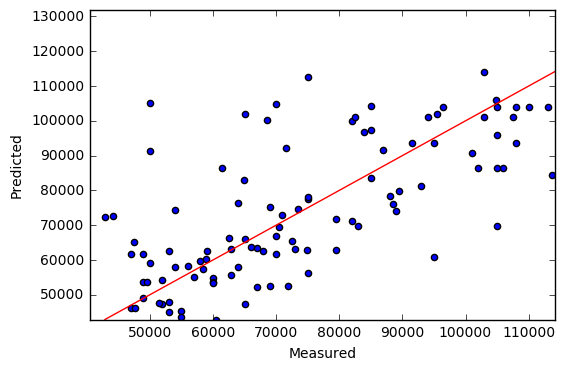

In [78]:
y = getNPArray(testGroundTruth)
predicted = getNPArray(predictionResult.get(prediction.prediction))
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(y,predicted)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
plt.xlim(predicted.min(),predicted.max())
plt.ylim(y.min(),y.max())
plt.xlabel('Measured')
plt.ylabel('Predicted')

plt.show()

# Testing your Model

## Error Measures:

### $R^2$


In [24]:
prediction_result = getNPArray(
    predictionResult.get(prediction.prediction))
real_values = getNPArray(testGroundTruth)

training_data_outcome = getNPArray(trainOutcome)

values_mean = np.sum(training_data_outcome)/len(training_data_outcome)

ssres = np.sum((real_values - prediction_result)**2)
sstot = np.sum((real_values - values_mean)**2)

r_squared = 1 - ssres / sstot

print("{0:.2f}".format(r_squared))

0.54


# Testing your Model

## Error Measures:

### $RMSE$


In [25]:
prediction_result = getNPArray(
    predictionResult.get(prediction.prediction))
real_values = getNPArray(testGroundTruth)

rmse = math.sqrt(
    np.sum((prediction_result-real_values)**2)/len(real_values))

print("{0:.2f}".format(rmse))

16480.70


# Clustering

In [26]:
n_clusters = 3
n_iterations = 10

clustering_data = np.genfromtxt('./iris.csv', delimiter=',')

variables = np.delete(clustering_data, np.s_[4::1], 1)

data_table = HomogenNumericTable(variables)

initAlg = init.Batch_Float64RandomDense(n_clusters)

initAlg.input.set(d, data_table)

res = initAlg.compute()
init_centroids = res.get(centroids)
# Create an algorithm object for the K-Means algorithm

algorithm = Batch_Float64LloydDense(n_clusters, n_iterations)

algorithm.input.set(d,data_table)
algorithm.input.set(inputCentroids, init_centroids)

res = algorithm.compute()

printNumericTable(res.get(kmeans.assignments), "Cluster assignments:")
printNumericTable(res.get(kmeans.centroids), "First 4 dimensions of centroids:", 3, 4)
printNumericTable(res.get(kmeans.goalFunction), "Goal function value:")

Cluster assignments:
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
1.000     
2.000     
0.000     
2.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
2.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     
0.000     


# Multiple inputs - splitting

In [27]:
nBlocks = 2
nFeatures = 4
nOutcomes = 1
trainDatasetFileNames = ['./housing-distributed-train1.csv', 
                         './housing-distributed-train2.csv']
masterAlgorithm = training.Distributed(step2Master)
for i in range(nBlocks):
    trainDataSource = FileDataSource(trainDatasetFileNames[i], 
                               DataSourceIface.notAllocateNumericTable,
                               DataSourceIface.doDictionaryFromContext)
    trainData = HomogenNumericTable(nFeatures, 0, 
                                    NumericTableIface.notAllocate)
    trainOutcome = HomogenNumericTable(nOutcomes, 0, 
                                       NumericTableIface.notAllocate)
    mergedData = MergedNumericTable(trainOutcome, trainData)
    nObservations = trainDataSource.loadDataBlock(mergedData)
    print("Observations read on file {}: {}".format((i+1), 
                                                    nObservations))
    localAlgorithm = training.Distributed(step1Local)
    localAlgorithm.input.set(training.data, trainData)    
    localAlgorithm.input.set(training.dependentVariables, 
                             trainOutcome)
    partialResult = localAlgorithm.compute()
    masterAlgorithm.input.add(training.partialModels, 
                              partialResult)

Observations read on file 1: 215
Observations read on file 2: 220


# Multiple input - merging results

In [28]:
masterAlgorithm.compute()

trainingResult = masterAlgorithm.finalizeCompute()
printNumericTable(trainingResult.get(training.model).getBeta(), 
                  "Linear Regression coefficients:")

Linear Regression coefficients:
-6356.393 6.127     2760.738  16551.026 7322.687  



# Testing your model

In [29]:
testDatasetFileName = './housing-test.csv'

testDataSource = FileDataSource(
    testDatasetFileName, DataSourceIface.doAllocateNumericTable,
    DataSourceIface.doDictionaryFromContext
)

testData = HomogenNumericTable(nFeatures, 0, 
                               NumericTableIface.notAllocate)
testGroundTruth = HomogenNumericTable(nOutcomes, 0, 
                                      NumericTableIface.notAllocate)
mergedData = MergedNumericTable(testGroundTruth,testData)

testDataSource.loadDataBlock(mergedData)

algorithm = prediction.Batch()

algorithm.input.setTable(prediction.data, testData)
algorithm.input.setModel(prediction.model, 
                         trainingResult.get(training.model))

predictionResult = algorithm.compute()

# Testing your model

In [30]:
printNumericTable(predictionResult.get(prediction.prediction), 
          "Linear Regression prediction results: (first 10 rows):", 10)
printNumericTable(testGroundTruth, "Ground truth (first 10 rows):", 10)

Linear Regression prediction results: (first 10 rows):
77584.291 
97463.689 
54689.190 
65962.833 
75165.556 
47366.503 
55175.751 
47366.503 
62841.671 
65407.807 

Ground truth (first 10 rows):
75000.000 
132000.000
60000.000 
65000.000 
69000.000 
51900.000 
57000.000 
65000.000 
79500.000 
72500.000 



# Any questions?